In [ ]:
!unzip train.zip

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import backend
import tensorflow as tf
import os
import cv2
import time
import math
import random
import re
import datetime
from IPython import display
from OceanPSC.GanGeneration.params import *
from OceanPSC.GanGeneration import CGAN
from OceanPSC.GanGeneration.data import load_dataset
from OceanPSC.GanGeneration.models import update_fadein

In [2]:

def generation_exemples(model, test_input, labels,cpt):
    prediction = model(labels,test_input)
    plt.figure(figsize=(15, 15))

    title = [class_names[i] for i in labels]
    n=int(nbr_exemples/3 + 0.99)

    for i in range(len(labels)):
        plt.subplot(n, 3, i+1)
        rescaled=prediction[i].numpy()
        plt.title(title[i])
        plt.imshow(prediction[i],cmap="gray")
        plt.axis('off')
        plt.savefig(f'{images_path}{gan.current_depth}_{gan.fade_in}_{cpt}.png',dpi=200)
        plt.show()

In [ ]:
train_dataset,class_names=load_dataset()
print(class_names)

['abp' 'active_margin' 'cr' 'csh' 'land_csh' 'mor' 'passive_margin' 'rs'
 's_abp' 's_rs' 'vrs']


In [ ]:

bruit_pour_exemple = tf.random.normal([nbr_exemples, bruit_dim],seed=1001)
labels_exemple=tf.range(nbr_exemples)

In [ ]:
def train_loop(epochs,batch_size,disc_los_min=-0.25,start_epoch=0):
    lses=[]
    start=time.time()
    steps=epochs*int(train_dataset.cardinality().numpy()/batch_size)
    start_cpt=int(steps*start_epoch/epochs)
    cpt=start_cpt
    update_fadein([gan.gen,gan.dis],cpt,steps)
    size=2**(gan.current_depth+2)
    disc_los=disc_los_min+1
    def transfo(img,label,ms):
    return tf.image.resize(img,(size,size),method='nearest'),label,ms
    for epoch in range(start_epoch,epochs):
    for image_batch,labels,mean_stds in train_dataset.map(transfo,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size):
        train_gen=True
        if disc_los>disc_los_min:
            train_gen=False
        gen_los,disc_los,wd=gan.train_step(image_batch,labels,mean_stds,train_gen)
        lses.append([gen_los.numpy(),disc_los.numpy(),wd.numpy(),train_gen])
        if cpt%10==0:
            print('.',end='',flush=True)
        if cpt%5000==0:
            gan.checkpoint.save(file_prefix=checkpoint_path+f"ckpt_{gan.current_depth}_{gan.fade_in}")
        if cpt%1000==0 or cpt==start_cpt:
            delta=time.time()-start
            display.clear_output(wait=True)
            generation_exemples(gan, bruit_pour_exemple, labels_exemple, cpt//1000)
            print(f'Currently at depth: {gan.current_depth}; fade_in={gan.fade_in}; size={size}. Epoch={epoch}/{epochs}')
            if (gan.fade_in):
                print(f'alpha={gan.gen.layers[-1].alpha.numpy()}')
            print('Training {}k/{}k: time elapsed {}'.format(cpt//1000,steps//1000, str(datetime.timedelta(seconds=delta))))
            print(f'Estimating remaining time: {datetime.timedelta(seconds=(delta)*((steps-start_cpt)/(cpt-start_cpt+1) - 1))}')
            lses=np.array(lses)
            lses=lses.mean(axis=0)
            print(f'gen_los={lses[0]}; dis_los={lses[1]}; dist={lses[2]}, train_gen={int(lses[3]*100)}%')
            lses=[]
            cpt+=1
            if gan.fade_in:
            update_fadein([gan.gen,gan.dis],cpt,steps)


In [ ]:
epochs=[[0,5], [5,5], [10,10], [15,15], [20,30], [20,50]]
batch_sizes=[20, 20, 20, 20, 20, 20]

In [ ]:
gan=CGAN()

In [ ]:
gan.current_depth=5
gan.fade_in=False
gan.load_latest()

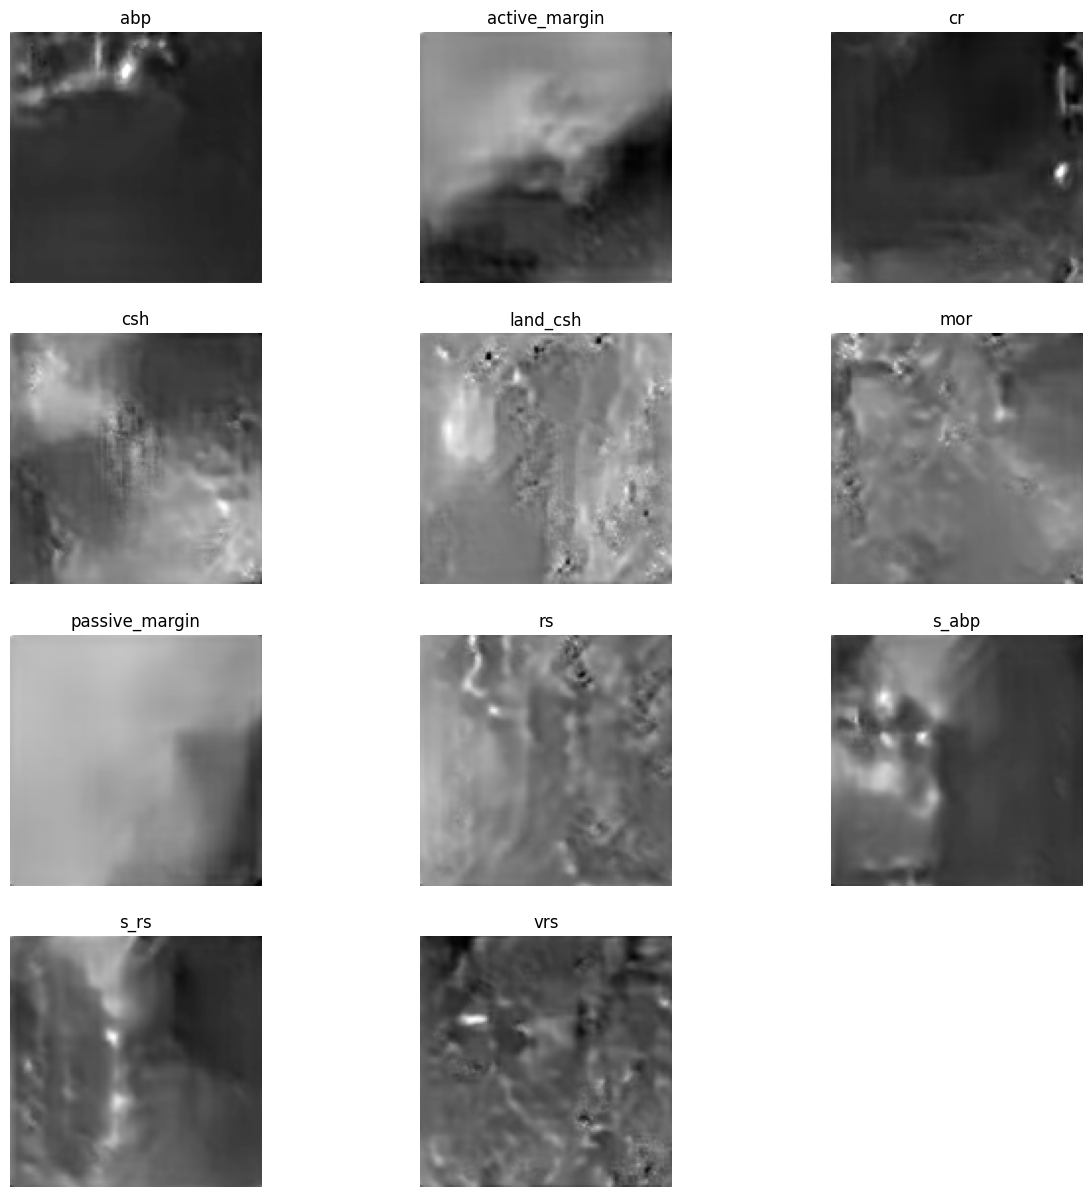

Currently at depth: 5; fade_in=False; size=128. Epoch=0/50
Training 0k/275k: time elapsed 0:00:03.597850
Estimating remaining time: 11 days, 10:50:05.044204
gen_los=4.8840742111206055; dis_los=1.0324532985687256; dist=0.9406633377075195, train_gen=0%


KeyboardInterrupt: ignored

In [ ]:
k=gan.current_depth
current_epochs=epochs[k][1]
current_batch_size=batch_sizes[k]
train_loop(current_epochs,current_batch_size)

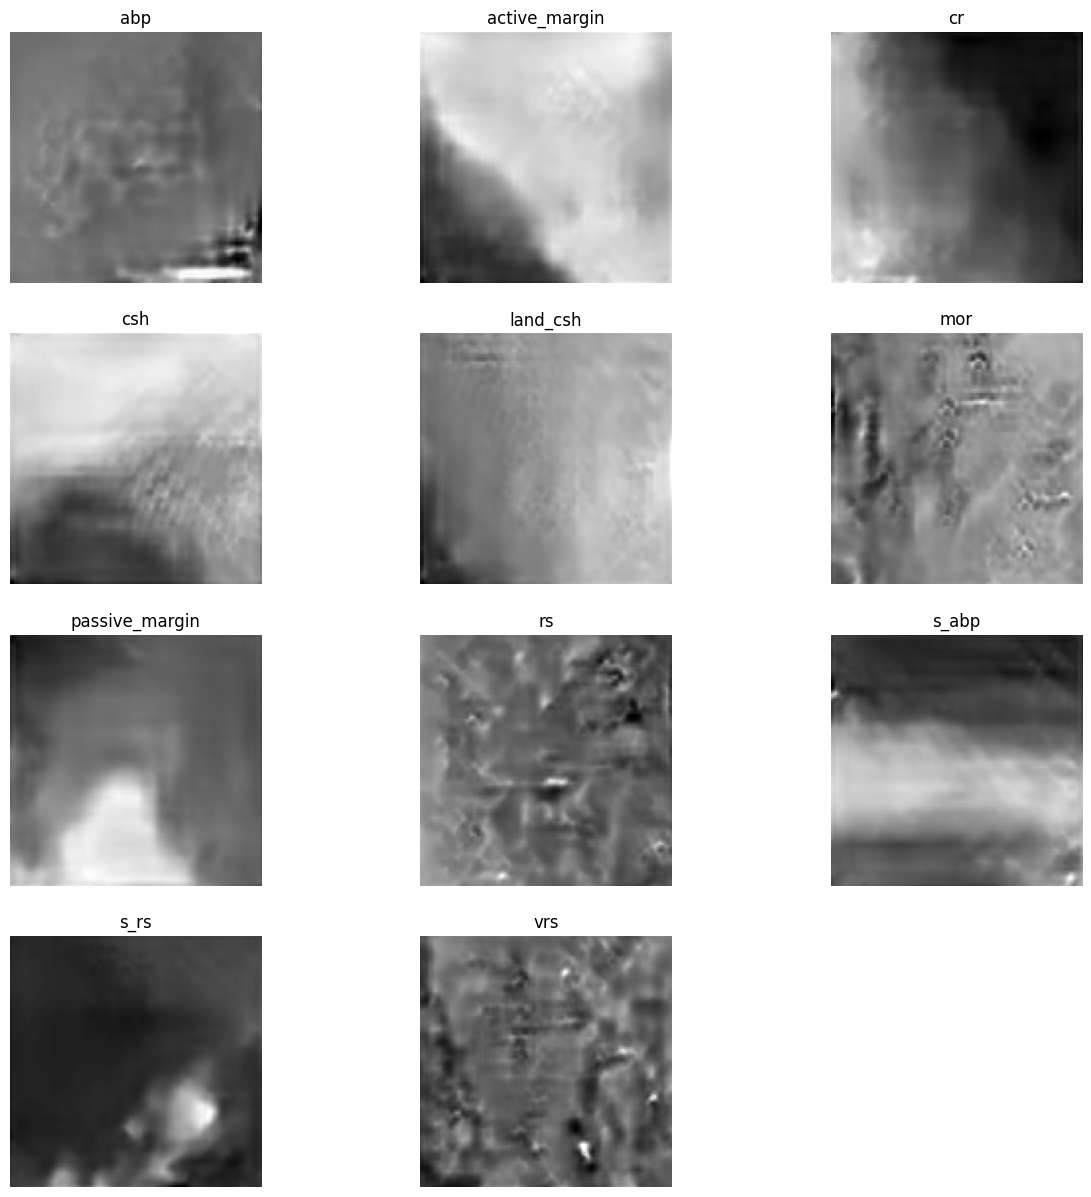

Currently at depth: 5; fade_in=True; size=128. Epoch=8/20
alpha=<tf.Variable 'ws_alpha:0' shape=() dtype=float32, numpy=0.43119663>
Training 48.0k/110k: time elapsed 14:11:39.877297
Estimating remaining time: 18:20:01.568562
gen_los=0.5165923833847046; dis_los=-0.6237480044364929; dist=-0.7372972965240479, train_gen=66%
...........................................................................................

KeyboardInterrupt: ignored

In [ ]:

start_depth=gan.current_depth
for k in range(start_depth,gan.max_depth+1):
    current_epochs=epochs[k][0]
    current_batch_size=batch_sizes[k]
    gan.current_depth=k
    gan.fade_in=True
    train_loop(current_epochs,current_batch_size)

    current_epochs=epochs[k][1]
    gan.fade_in=False
    train_loop(current_epochs,current_batch_size)


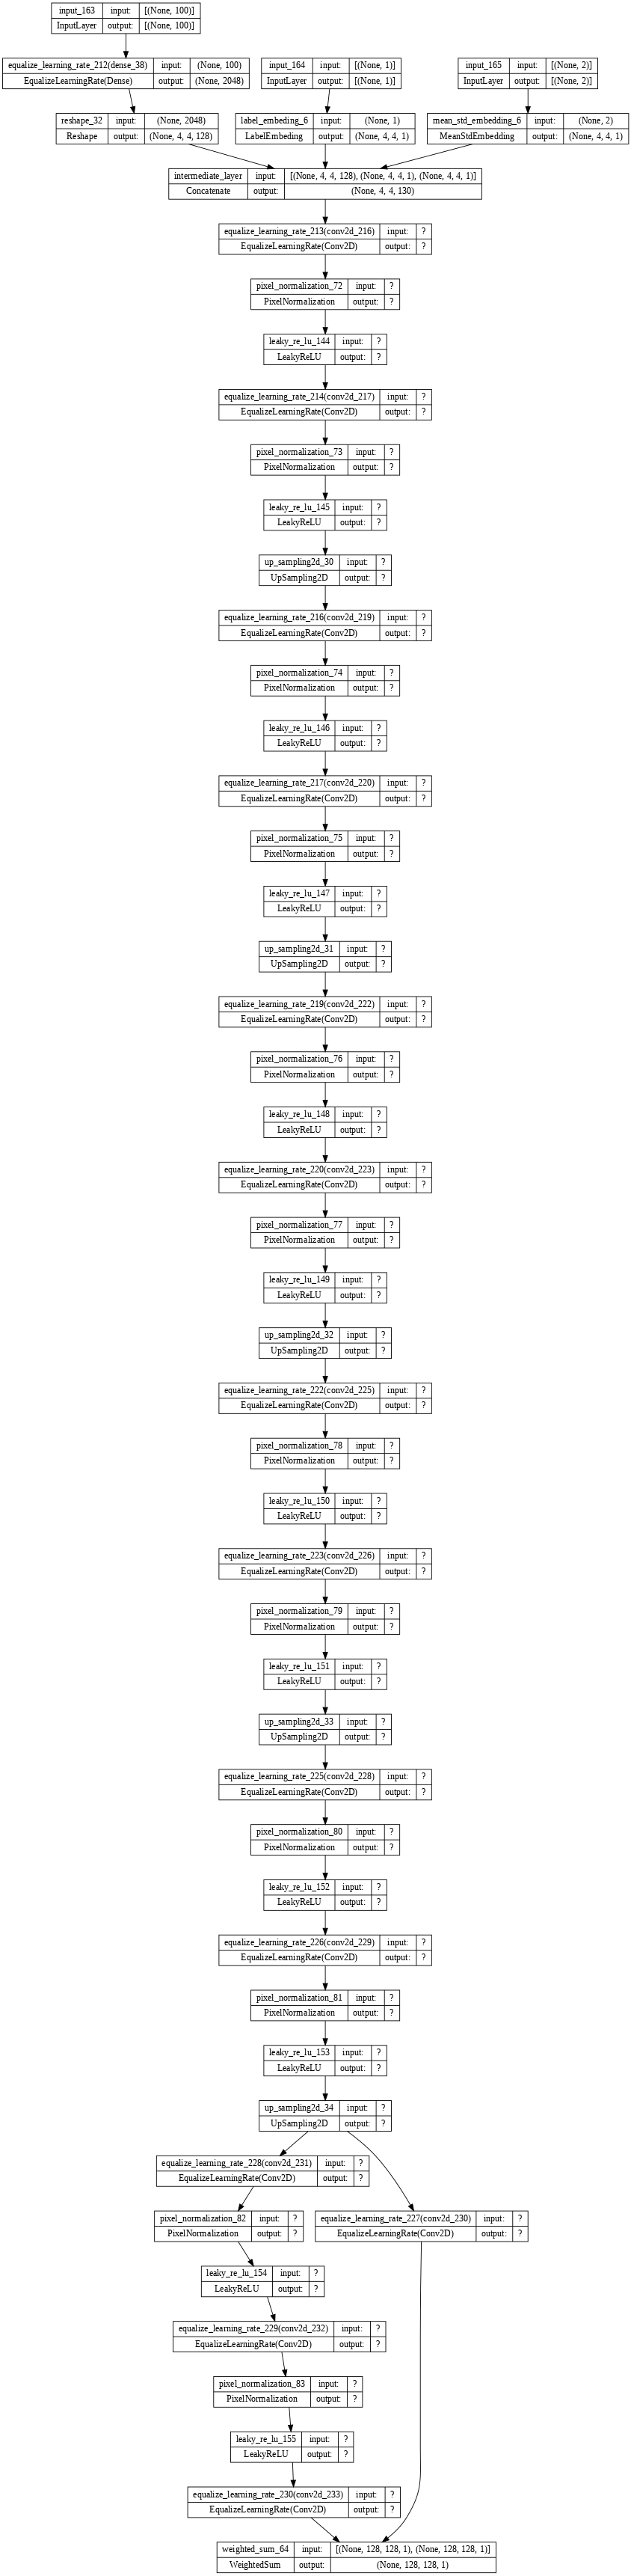

In [ ]:

tf.keras.utils.plot_model(gan.gen, show_shapes=True, dpi=64)

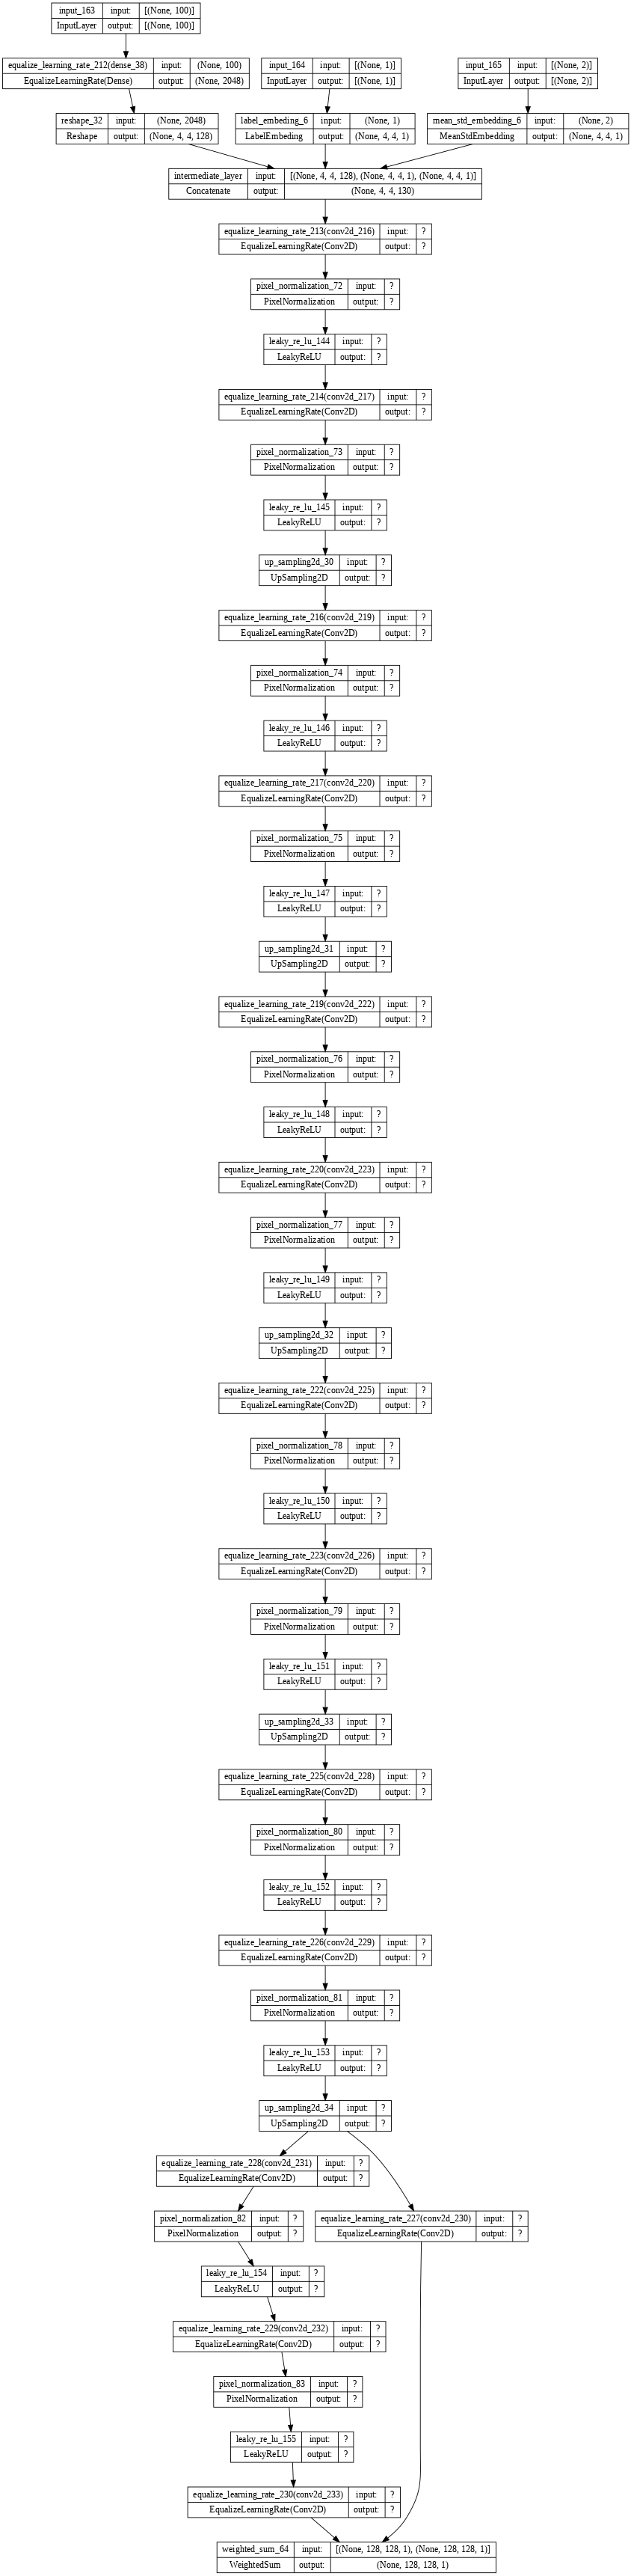

In [ ]:

tf.keras.utils.plot_model(gan.gens[-1][1], show_shapes=True, dpi=64)